In [1]:
import nltk
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from functools import partial
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
pd.value_counts(data['keyword'])

fatalities               45
armageddon               42
deluge                   42
damage                   41
body%20bags              41
sinking                  41
harm                     41
fear                     40
outbreak                 40
twister                  40
evacuate                 40
siren                    40
collided                 40
windstorm                40
explosion                39
whirlwind                39
weapon                   39
sinkhole                 39
derailment               39
famine                   39
wreckage                 39
wrecked                  39
flames                   39
sunk                     39
hellfire                 39
weapons                  39
collision                39
earthquake               39
bombed                   38
oil%20spill              38
                         ..
trauma                   31
wild%20fires             31
terrorist                31
dead                     30
catastrophic        

In [13]:
pd.value_counts(data['location'])

USA                              104
New York                          71
United States                     50
London                            45
Canada                            29
Nigeria                           28
UK                                27
Los Angeles, CA                   26
India                             24
Mumbai                            22
Washington, DC                    21
Kenya                             20
Worldwide                         19
Chicago, IL                       18
Australia                         18
California                        17
New York, NY                      15
California, USA                   15
Everywhere                        15
San Francisco                     14
United Kingdom                    14
Florida                           14
Washington, D.C.                  13
Los Angeles                       13
Indonesia                         13
Ireland                           12
NYC                               12
T

In [17]:
# Null category is probably okay for this.
np.sum(data['keyword'].isna())

61

In [18]:
# Probably too many nulls to be useful.
np.sum(data['location'].isna())

2533

In [19]:
# Example default tokenization
nltk.word_tokenize(data['text'][0])

['Our',
 'Deeds',
 'are',
 'the',
 'Reason',
 'of',
 'this',
 '#',
 'earthquake',
 'May',
 'ALLAH',
 'Forgive',
 'us',
 'all']

In [ ]:
# One possible idea: Use the default tokenization, and just remove the hashtag symbols

In [4]:
# Tokenizer for Twitter derived tweetmotif from the ARK, developed at CMU
tweetMotif = r''' (?x)	# set flag to allow verbose regexps
      (?:https?://|www)\S+      # simple URLs
      | (?::-\)|;-\))		# small list of emoticons
      | &(?:amp|lt|gt|quot);    # XML or HTML entity
      | \#\w+                 # hashtags
      | @\w+                  # mentions   
      | \d+:\d+               # timelike pattern
      | \d+\.\d+              # number with a decimal
      | (?:\d+,)+?\d{3}(?=(?:[^,]|$))   # number with a comma
      | (?:[A-Z]\.)+                    # simple abbreviations
      | (?:--+)               # multiple dashes
      | \w+(?:-\w+)*          # words with internal hyphens or apostrophes
      | ['\".?!,:;/]+         # special characters
      '''

In [43]:
nltk.regexp_tokenize(data['text'][0], tweetMotif)

['Our',
 'Deeds',
 'are',
 'the',
 'Reason',
 'of',
 'this',
 '#earthquake',
 'May',
 'ALLAH',
 'Forgive',
 'us',
 'all']

In [5]:
all_tokens = []
for i in range(len(data)):
    all_tokens.extend(nltk.regexp_tokenize(data['text'][i].lower(), tweetMotif))

In [6]:
len(all_tokens)

126976

In [7]:
# Remove duplicates.
tokens_unique = list(set(all_tokens))

In [8]:
len(tokens_unique)

23003

In [60]:
tokens_unique[0:10]

['http://t.co/zdj2hyf6ro',
 'http://t.co/20twgpmm7d',
 'hopped',
 'bs',
 'palms',
 'specif',
 'lexi',
 '#handbag',
 'market',
 '@barackobama']

In [9]:
# Remove URLs and mentions
token_basis = list(filter(lambda t: ('@' not in t and '//' not in t), tokens_unique))
token_basis.sort()

In [10]:
len(token_basis)

16087

In [72]:
token_basis[0:50]

['!',
 '!!',
 '!!!',
 '!!!!',
 '!!!!!',
 '!!!!!!',
 '!!!!!!!!!!',
 '!!!!!!!!!!!',
 '!!!!!!!!!!!!',
 "!!!!'",
 '!!!!.',
 '!!!...',
 '!!!????',
 '!!:',
 "!!?!?!?!'",
 "!!?!??!?'",
 '!!??',
 '!!????',
 "!'",
 '!:',
 '!?',
 '!?!',
 '!??',
 '#0215',
 '#034',
 '#039',
 '#06',
 '#09',
 '#1',
 '#1008pla',
 '#1008planet',
 '#124',
 '#140',
 '#16',
 '#163',
 '#17',
 '#171',
 '#2015',
 '#20150613',
 '#22days',
 '#24',
 '#263chat',
 '#2a',
 '#2fast2furious',
 '#2minutemix',
 '#3',
 '#360wisenews',
 '#365disasters',
 '#37592',
 '#38745']

In [64]:
pd.value_counts(all_tokens)

the                       3272
.                         3190
'                         2935
a                         2196
in                        1980
to                        1946
:                         1934
of                        1828
i                         1757
and                       1424
is                         949
s                          908
...                        906
you                        901
for                        893
on                         855
it                         777
!                          691
my                         678
that                       623
with                       572
?                          551
at                         542
by                         525
this                       480
t                          477
from                       422
be                         407
are                        404
was                        386
                          ... 
usage                        1
perrie  

In [11]:
documents = [text.lower() for text in data['text']]

In [12]:
vec = CountVectorizer(analyzer = partial(nltk.regexp_tokenize, pattern=tweetMotif))

In [13]:
cv = vec.fit_transform(documents)

In [14]:
df = pd.DataFrame(cv.toarray(), columns=vec.get_feature_names())

In [118]:
df.columns[-100:]

Index(['zero', 'zeros', 'zhejiang', 'zicac', 'zimbabwe', 'zimmer',
       'zimpapersviews', 'zionist', 'zionists', 'zip', 'zipped', 'zipper',
       'zippers', 'ziuw', 'zmne', 'zodiac', 'zombie', 'zombies', 'zone',
       'zones', 'zonewolf123', 'zoom', 'zotar', 'zouma', 'zrnf', 'zss',
       'zumiez', 'zurich', 'zzzz', 'ââ', 'ã', 'å', 'å_', 'åç', 'åè',
       'åèmgn-africaå', 'åê', 'åêfedex', 'åêi', 'åêm', 'ì', 'ìñ', 'ìñ1', 'ìü',
       'û', 'û_', 'û_1', 'û_ahhh', 'û_https', 'û_one', 'û_that', 'û_turns',
       'û_you', 'ûª', 'ûª93', 'ûªa', 'ûªarabia', 'ûªd', 'ûªll', 'ûªm', 'ûªre',
       'ûªs', 'ûªt', 'ûªve', 'ûï', 'ûïa', 'ûïafter', 'ûïairplane', 'ûïall',
       'ûïcat', 'ûïdetonate', 'ûïfor', 'ûïhatchet', 'ûïi', 'ûïlittle',
       'ûïlove', 'ûïmake', 'ûïnews', 'ûïnobody', 'ûïnumbers', 'ûïparties',
       'ûïplans', 'ûïrichmond', 'ûïsippin', 'ûïstretcher', 'ûïthat', 'ûïthe',
       'ûïwe', 'ûïwhen', 'ûïyou', 'ûò', 'ûò800000', 'ûòthe', 'ûòåêcnbc', 'ûó',
       'ûóher', 'ûókody', 'ûóne

In [15]:
len(df.columns)

23003

In [20]:
# Could also remove the tokens that only occur once, since they couldn't be useful...
# Comparing what happens when these columns for tokens that only occur once are dropped
toDrop = []
for i in range(len(df.columns)):
    if df.columns[i].startswith('@') or '//' in df.columns[i] or np.sum(df[df.columns[i]]) == 1:
        toDrop.append(df.columns[i])
print(len(toDrop))

16267


In [21]:
# Drop these columns
df_simple = df.drop(columns=toDrop)

In [22]:
# Underscore added because some of these are existing columns
df_lab = df_simple.copy()
#df_lab['_id'] = data['id']
df_lab['_keyword'] = data['keyword']
df_lab['_location'] = data['location']
df_lab['_target'] = data['target']

In [23]:
df_simple.shape

(7613, 6736)

In [253]:
np.random.seed(1)
train, test = train_test_split(df_lab) # 25%

In [254]:
train.shape

(5709, 6740)

In [255]:
test.shape

(1904, 6740)

In [256]:
# No information rate (accuracy of a model which just predicts 'no' every time) 
1 - np.sum(df_lab['_target'])/df_lab.shape[0]

0.5703402075397347

In [257]:
df.shape

(7613, 23003)

In [291]:
df_lab.shape

(7613, 16090)

In [290]:
df_lab.to_csv("tdm.csv", index=False)

In [288]:
df_lab.head()

,!,!!,!!!,!!!!,!!!!!,!!!!!!,!!!!!!!!!!,!!!!!!!!!!!,!!!!!!!!!!!!,!!!!',...,ûó,ûóher,ûókody,ûónegligence,ûótech,ûówe,_id,_keyword,_location,_target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,NaN,NaN,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,NaN,NaN,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,NaN,NaN,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,NaN,NaN,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,NaN,NaN,1


In [269]:
# Come to think of it, I need to add in the data from the training set, too
df_test = pd.read_csv('test.csv')

In [280]:
all_test_tokens = []
for i in range(len(df_test)):
    all_test_tokens.extend(nltk.regexp_tokenize(df_test['text'][i].lower(), tweetMotif))

In [281]:
len(all_test_tokens)

54712

In [282]:
# Remove duplicates.
test_tokens_unique = list(set(all_test_tokens))
len(test_tokens_unique)

12969

In [283]:
# Remove URLs and mentions
test_token_basis = list(filter(lambda t: ('@' not in t and '//' not in t), test_tokens_unique))
test_token_basis.sort()
len(test_token_basis)

9792

In [286]:
# Words that don't occur at all in the training data
count = 0
for i in range(len(test_token_basis)):
    if test_token_basis[i] not in token_basis:
        count += 1
        print(test_token_basis[i])

!!!!!!!!!
!!!!:
!!!?
!!!??
!!'
!...
!?'
!????
#05
#0518
#12k
#1oak
#2
#21dayfix
#26
#3682
#4552
#5sosquotes
#666
#7294
#7news
#8nn
#aapatwork
#acapella
#acreativedc
#action
#addiction
#advancedwarfare
#aftermath
#album
#aleppo
#alfa
#alwaysaho
#amazingracecanada
#amerikkka
#amtrak
#amwriting
#ancient
#anime
#anticipate
#aphid
#apocalyptic
#aquarius
#archives
#around
#article
#artwork
#askceeps
#atx
#audiobook
#auditiontime
#autistic
#autoaccidents
#avril
#awesomejobsiri
#badcredit
#badge
#badgeofhonour
#bag
#bald
#baltistan
#bananalivesmatter
#bashir
#bbclive
#bblf
#bbmeg
#bds
#bears
#beastburger
#beauty
#behindthescenes
#bestdayeva
#beyondmeat
#bfc630nz
#bgc14
#bidtime
#bigdata
#bikecommute
#birdgang
#black
#blackforestgateau
#blackhat
#bleedinglove
#blight
#blinds
#blizzard
#blowjob
#blowvape
#bokoharm
#bombeffects
#boomshunga
#bosvsnyy
#bot
#boyxboy
#braininjury
#britain
#british
#brokelynati
#btsprep
#builder
#buildingmuseum
#buybloodonthedanceflooronitunes
#byebyeroad
#bynr
#caigu

au
aucklnd
auditory
aug06
aunft
aunts
aus
authoritarian
auto-mechanics
autocracies
automated
autopsy
avalon
avast
avery
avocado
awaken
awakened
awakening
award
awe
awg
awh
awhile
axegressor
axle
axwave
aya
ayatollah
az
azeroth
azz
baa
baba
backroad
backtracking
backwards
bacon
bacup
badging
bailout
ballad
ballina
balloon
bananas
banging
banished
banjo
bankruptcy
barbarism
barracuda
barrel
barton
barton-le-clay
bashed
batch
bateman
bathed
batman
baume
bayonet
bcc
bdays
beaches
beads
beartooth
beau
becuase
bedhair
beds
bedtime
beez
befoooooooore
begovic
beings
believer
believers
believes
belittled
belo-ooow
beloved
benefit
benghazi
berggruen
beta
bethesda
beyoncì
bharat
bhill
bible
bickford
bigfoot
bihar
bikes
billet
billie
billion-dollar
billowing
biltz
bimbo
bins
biometrics
bit-defender
bitchy
bitterroot
bivens
bizinsider
blairs
blankets
bldy
bleach
bleased
blighted
blinded
blissfully
blizzards
blockade
blown-up
bnvfdag
bo
bo2
boarders
bodily
bogged
bol-apm
bolan
bolts
bombarded
bombar

krag
kristy
krnv
ks225
ksl
ktchn
ktla
kudo
kumasian
kunais
kwxggt
kylie
kyodonews
l-h4
lads
lakers
laleh
lambasted
lancaster
landmark
landslide-damaged
langhorne-middletown
lanka
lapses
laptop
lashed
lasso
lasts
laters
latter
launched
lavera
lawmakers
layers
lb
le
leaf
leaveevacuateexitbe
leesburg
leftover
leftside
legends
leigh
lend
leona
leone
les
lewes
lexington
lgbt
liam
liberals
libertyville
lick
lides
lifes
lifesaving
lift
lightroom
lik
likkly
lilly
linden
liners
linford
liquid
lisa
listeners
lists
lithgow
litigation
liz
lizeth
lizzie
lj
lmk
lobbyists
lobster
lockstep
loft
lofty
longe
lookin
lookout
looming
loser
lotm
louisan
lovers
low-carb
lowers
lozano
lp
ltd
lto-5
luckily
luggage
lump
lunacy
lunatics
lupe
lust
lustig
lvl
ly
lydia
lyk
lyricaleyes
lìä
m9a1
macabre
macomb
macy
madonna
madsummer
maghar
magically
magna-fi
mailer
maimonides
maintaining
maisy
majors
makers
makeup
makinwa
makoto
makurazaki
malfunctioning
malone
malyasiaairlines
manayunk
manhood
mani
manipur
manner
ma

tencent
ter
terraria
terrellt
terrence
terri
terry
tess
testament
tetovo
texian
tfd
thane
thanksgiving
thar
theaters
thediyhacks
then0mads0ul
theocracy
theonion
therapist
therese
thereåêwere
thermostat
theyll
thezlong
thicker
thieves
thine
thing2
thinkin
thirty-one
thompson
thong
thorcon
thorium
threshold
thrift
thrive
throws
thrusting
thugs
ti
tia
tibetan
tickens
tightens
timas
timbering
timedoes
timelapse
times4
timesnewsdesk
tink
tipped
tisa
titled
tksgs0810
tl
tltltltltlttlt
tmh
to-dos
to-read
tobacco
tobias
toed
toke
tomb
tommygshow
tonka
toothpaste
toothsome
torches
torpedoed
tory
touches
tourniquet
towel
towline
toy
tractor-trailers
tradery
trafficking
tragedies
trailers
trainees
trama
trampoline
transact
transmission
transocean
transported
trapping
trashcans
travelled
travels
tre
treats
tribulation
tribute
triplemania
trolleys
trolls
tropic
tropics
truely
truthfrequencyradio
tryin
tsa
ttk
tuition
tulsa
tumbleon
tunes
turban
turnpike
tut
tutu
twisted
twitterpated
two-tone
twp
ty

In [287]:
print(count)

3808


In [ ]:
# Simple random forest predictor on the TDM
# Out of bag estimates on this one make the train/test split kind of pointless.

In [298]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True)

In [299]:
rf.fit(df_simple, data['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [300]:
rf.oob_score_

0.7862866150006568

In [ ]:
# Not too bad, really.

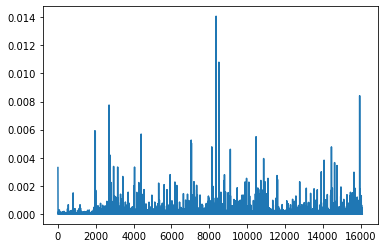

In [302]:
plt.plot(rf.feature_importances_)

In [304]:
print(np.max(rf.feature_importances_))
print(np.argmax(rf.feature_importances_))

0.014074450774809946
8361


In [307]:
# This is the same column that has the largest difference in means between the two classifications.
df_simple.columns[8361]

'i'

In [ ]:
# This just looks at the word counts within each tweet without caring about the order of the words or anything.
# Better NLP techniques would take the order into consideration.

In [24]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True)

In [25]:
# This time with words that only occur once removed
rf.fit(df_simple, data['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
rf.oob_score_

0.7807697359779325

In [31]:
# Removing the words that only occurred once only decreasd the OOB score by 0.6%.
# Now, let me see if I can tune this random forest a bit better.
rf = RandomForestClassifier(n_estimators=250, oob_score=True)
rf.fit(df_simple, data['target'])
rf.oob_score_

0.7876001576251149

In [41]:
rf2 = RandomForestClassifier(n_estimators=500, oob_score=True)
rf2.fit(df_simple, data['target'])
rf2.oob_score_

0.7890450545120189

In [42]:
rf3 = RandomForestClassifier(n_estimators=1000, oob_score=True)
rf3.fit(df_simple, data['target'])
rf3.oob_score_

0.7902272428740312